In [155]:
import pandas as pd
import category_encoders
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from tqdm import tqdm
from scipy.stats import zscore
import numpy as np
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.ensemble import IsolationForest

C:\Users\User\AppData\Local\Temp\ipykernel_27756\4141443420.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test['해당층'])


<Axes: xlabel='해당층', ylabel='Density'>

C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 52789 (\N{HANGUL SYLLABLE CEUNG}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\p

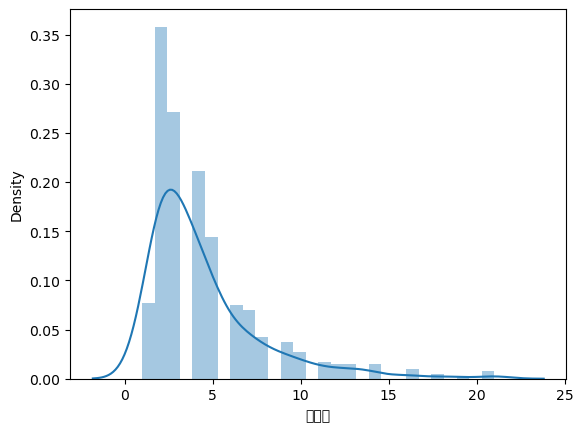

In [44]:
sns.distplot(test['해당층'])

In [156]:
def basic_data_processing():
    train = pd.read_csv('./train.csv')
    test = pd.read_csv('./test.csv')
    
    train['총주차대수'] = train['총주차대수'].fillna(0)
    test['총주차대수'] = test['총주차대수'].fillna(0)
    
    train['year'] = pd.to_datetime(train['게재일']).dt.year
    train['month'] = pd.to_datetime(train['게재일']).dt.month
    test['year'] = pd.to_datetime(test['게재일']).dt.year
    test['month'] = pd.to_datetime(test['게재일']).dt.month
#     train['day'] = pd.to_datetime(train['게재일']).dt.day
#     test['day'] = pd.to_datetime(test['게재일']).dt.day
    train = train.drop(['ID','게재일'],axis=1)
    test = test.drop(['ID','게재일'],axis=1)
#     train['전용면적'] = train['전용면적'].fillna(0).apply(lambda x: 0 if x == 0 else 1)
#     test['전용면적'] = test['전용면적'].fillna(0).apply(lambda x: 0 if x == 0 else 1)
    train = train.fillna(0)
    test = test.fillna(0)
    
    str_cols = ['매물확인방식','방향','주차가능여부','중개사무소','제공플랫폼','전용면적']
    for col in str_cols:
        encoder = category_encoders.TargetEncoder(cols=[col],smoothing=2,min_samples_leaf=5)
        train[col] = encoder.fit(train[col],train['허위매물여부'])
        train[col] = encoder.transform(train[col])
        test[col] = encoder.transform(test[col])
        
        encoder = OneHotEncoder(sparse_output=False)


    return train, test

In [168]:
train = pd.read_csv('./train.csv')
str_cols = ['매물확인방식','방향','주차가능여부','중개사무소','제공플랫폼','전용면적']
for col in str_cols:
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(train[[col]])
    print(pd.DataFrame(encoded,columns=encoder.get_feature_names_out([col])))

      매물확인방식_서류확인  매물확인방식_전화확인  매물확인방식_현장확인
0             0.0          0.0          1.0
1             0.0          0.0          1.0
2             0.0          1.0          0.0
3             0.0          0.0          1.0
4             0.0          0.0          1.0
...           ...          ...          ...
2447          1.0          0.0          0.0
2448          1.0          0.0          0.0
2449          0.0          1.0          0.0
2450          0.0          0.0          1.0
2451          0.0          1.0          0.0

[2452 rows x 3 columns]
      방향_남동향  방향_남서향  방향_남향  방향_동향  방향_북동향  방향_북서향  방향_북향  방향_서향
0        0.0     0.0    0.0    0.0     0.0     0.0    0.0    1.0
1        1.0     0.0    0.0    0.0     0.0     0.0    0.0    0.0
2        0.0     0.0    0.0    1.0     0.0     0.0    0.0    0.0
3        1.0     0.0    0.0    0.0     0.0     0.0    0.0    0.0
4        0.0     0.0    0.0    1.0     0.0     0.0    0.0    0.0
...      ...     ...    ...    ...     ...     ...    ...

In [157]:
train, test = basic_data_processing()
train.info()

ValueError: Expected 2D array, got 1D array instead:
array=['현장확인' '현장확인' '전화확인' ... '전화확인' '현장확인' '전화확인'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [146]:
train, test = basic_data_processing()

target = '허위매물여부'
cut_ratio = 0.0
test_size = 0.1
cv = 10

X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[[target]], test_size=test_size, stratify=train[[target]], random_state=42)

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42, verbose=0)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# 각 모델의 feature importance를 얻습니다.
lgbm_importance = lgbm.feature_importances_
xgb_importance = xgb.feature_importances_
catboost_importance = catboost.feature_importances_

# 각 모델의 feature importance를 합산합니다.
total_importance = lgbm_importance + xgb_importance + catboost_importance
total_importance = xgb_importance

# 중요도를 기준으로 상위 90%의 피쳐를 유지
threshold = np.percentile(total_importance, cut_ratio*100)
selected_features = X_train.columns[total_importance >= threshold]

# 유지된 피쳐를 기반으로 데이터를 업데이트
X_train = X_train[selected_features]
X_test = X_test[selected_features]
test = test[selected_features]

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42, max_depth=8)
xgb = XGBClassifier(random_state=42, learning_rate=0.1, max_depth=8, n_estimators=100)
catboost = CatBoostClassifier(random_state=42, max_depth=8, verbose=0)
# rf = RandomForestClassifier(random_state=42, oob_score=True)
iso = IsolationForest(random_state=42, contamination=0.11)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)
iso.fit(X_train, y_train)

# 소프트 보팅 앙상블 모델 생성
ensemble_model = VotingClassifier(estimators=[
   ('lgbm', lgbm),
    ('xgb', xgb),
    ('catboost', catboost),
#    ('rf', rf)
], voting='soft')

# Cross validation을 위한 StratifiedKFold 사용
cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)

# f1_score를 평가 지표로 사용
scorer = make_scorer(f1_score, average='macro')

# 각 모델과 앙상블 모델에 대해 cross validation 수행
lgbm_cv_scores = cross_val_score(lgbm, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
xgb_cv_scores = cross_val_score(xgb, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
catboost_cv_scores = cross_val_score(catboost, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
# rf_cv_scores = cross_val_score(rf, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
ensemble_cv_scores = cross_val_score(ensemble_model, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
iso_cv_scores = cross_val_score(iso, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)

# 결과 출력
print(f"LGBM Cross Validation Macro F1 Scores: {np.mean(lgbm_cv_scores)}")
print(f"XGBoost Cross Validation Macro F1 Scores: {np.mean(xgb_cv_scores)}")
print(f"CatBoost Cross Validation Macro F1 Scores: {np.mean(catboost_cv_scores)}")
# print(f"RamdomForest Cross Validation Macro F1 Scores: {np.mean(rf_cv_scores)}")
print(f"Ensemble Model Cross Validation Macro F1 Scores: {np.mean(ensemble_cv_scores)}")
print(f"iso Model Cross Validation Macro F1 Scores: {np.mean(iso_cv_scores)}")


C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y

LGBM Cross Validation Macro F1 Scores: 0.837586289255011
XGBoost Cross Validation Macro F1 Scores: 0.72541135487583
CatBoost Cross Validation Macro F1 Scores: 0.7804407428320472
Ensemble Model Cross Validation Macro F1 Scores: 0.8275158416462765
iso Model Cross Validation Macro F1 Scores: 0.07112224812224813


In [147]:
iso_cv_scores

array([0.07692308, 0.05333333, 0.05128205, 0.08      , 0.07407407,
       0.09090909, 0.08333333, 0.04444444, 0.08      , 0.07692308])

In [148]:
iso.predict(test)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [137]:
lgb_pred = [i[1] for i in lgbm.predict_proba(test)]
xgb_pred = [i[1] for i in xgb.predict_proba(test)]
cat_pred = [i[1] for i in catboost.predict_proba(test)]

sub = pd.read_csv('./sample_submission.csv')
l,x,c = 0.35,0.35,0.3
threshold = 0.33
pred = [l*lgb_pred[i] + x*xgb_pred[i] + c*cat_pred[i] for i in range(len(sub))]
print('Train ratio:',len(train[train['허위매물여부'] == 1])/len(train))
print('Prediction answer ratio:',len([i for i in pred if i > threshold])/len(pred))

answer = []
for p in pred:
    if p > threshold:
        answer.append(1)
    else:
        answer.append(0)

sub['허위매물여부'] = answer
sub.to_csv('./answer.csv',index=False)

Train ratio: 0.12153344208809136
Prediction answer ratio: 0.10277324632952692


In [154]:
iso_pred = iso.predict(test)
sub = pd.read_csv('./sample_submission.csv')

for i in range(len(iso_pred)):
    if iso_pred[i] == -1:
        iso_pred[i] = 0

print('Train ratio:',len(train[train['허위매물여부'] == 1])/len(train))
print('Prediction answer ratio:',1-sum(iso_pred)/len(sub))



sub['허위매물여부'] = iso_pred
sub.to_csv('./answer.csv',index=False)

Train ratio: 0.12153344208809136
Prediction answer ratio: 0.09135399673735722


# ranked
test 0.2
cv 10
threshold 0.25
lgb 1, xgb 0, cat 0

C:\Users\User\AppData\Local\Temp\ipykernel_27756\2016596573.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred)


<Axes: ylabel='Density'>

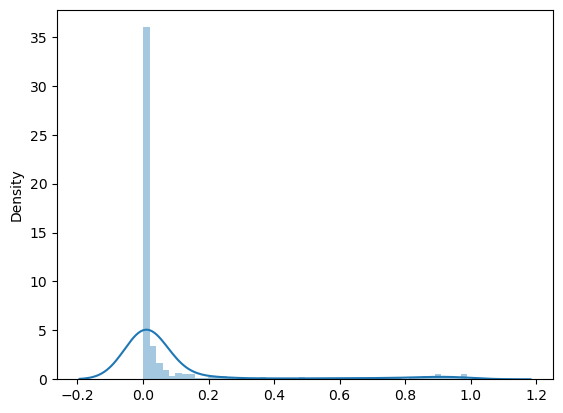

In [116]:
sns.distplot(pred)